In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

tqdm.pandas()

pd.set_option('display.max_columns', None)

# Validate house fire index

Author: Jack Vandeleuv

The goal of this notebook is to compare and contrast different ways of ranking cities by fire hazard.

## Clean and preprocess

In [2]:
df = pd.read_csv('../data/processed/nfirs_pop_merge_filter_reac.csv')

Clean up dataset.

In [3]:
df = df[df.POPULATION.notna()]

Get population adjusted NFIRS counts

In [4]:
df['sum_loss'] = df['SUM_PROP_LOSS'] + df['SUM_CONT_LOSS']
df['sum_death'] = df['SUM_OTH_DEATH'] + df['SUM_FF_DEATH']
df['sum_injury'] = df['SUM_OTH_INJ'] + df['SUM_FF_INJ']

Calculate new adjusted values, per capita and per fire.

In [5]:
to_population_adjust = [
    'sum_loss', 'sum_death', 'sum_injury', 'TOTAL_INCIDENT_COUNT'
]

to_total_incident_count_adjust = [
    'COUNT_111','COUNT_111', 'COUNT_113',
    'COUNT_131', 'COUNT_151', 'COUNT_142', 'SUM_SPREAD'
]

for col in to_population_adjust:
    df['ADJ_' + col] = df[col] / df.POPULATION

for col in to_total_incident_count_adjust:
    df['ADJ_' + col] = df[col] / df.TOTAL_INCIDENT_COUNT

df['house_fires_per_capita'] = df['COUNT_111'] / df.POPULATION
df['cooking_fires_per_capita'] = df['COUNT_113'] / df.POPULATION

Rename columns for readability.

In [6]:
df = df.rename(columns={
    'ADJ_COUNT_111': 'sum_111_per_fire', 
    'ADJ_COUNT_113': 'sum_113_per_fire', 
    'ADJ_COUNT_131': 'sum_131_per_fire', 
    'ADJ_COUNT_151': 'sum_151_per_fire', 
    'ADJ_COUNT_142': 'sum_142_per_fire', 
    'ADJ_SUM_SPREAD': 'sum_secondary_fires_per_fire',
    'ADJ_sum_loss': 'money_lost_per_capita',
    'ADJ_sum_death': 'deaths_per_capita',
    'ADJ_sum_injury': 'injuries_per_capita',
    'ADJ_TOTAL_INCIDENT_COUNT': 'fires_per_capita'
})

## Calculate candidate indices

A higher rank means more of the bad thing.

In [7]:
df.deaths_per_capita.max()

0.012448132780082987

In [8]:
df['injuries_per_capita_rank'] = df.groupby('YEAR_x')['injuries_per_capita'].rank()
df['house_fires_per_capita_rank'] = df.groupby('YEAR_x')['house_fires_per_capita'].rank()
df['deaths_per_capita_rank'] = df.groupby('YEAR_x')['deaths_per_capita'].rank()
df['money_lost_per_capita_rank'] = df.groupby('YEAR_x')['money_lost_per_capita'].rank()
df['spread_rank'] = df.groupby('YEAR_x')['sum_secondary_fires_per_fire'].rank()


For each ranking, we'll check the floor, where all cities are tied.

In [9]:
print("Minimum injuries per capita rank is:", df['injuries_per_capita_rank'].min())
print("Minimum house fires per capita rank is:", df['house_fires_per_capita_rank'].min())
print("Minimum deaths per capita rank is:", df['deaths_per_capita_rank'].min())
print("Minimum money lost per capita rank is:", df['money_lost_per_capita_rank'].min())
print("Minimum spread rank is:", df['spread_rank'].min())

Minimum injuries per capita rank is: 2138.5
Minimum house fires per capita rank is: 128.0
Minimum deaths per capita rank is: 2880.5
Minimum money lost per capita rank is: 591.5
Minimum spread rank is: 2539.0


## Check stability across years

### Look at percentage of zero values

Deaths per capita, perhaps the most important metric, is zero most years for most cities. However, other metrics like injuries per capita and house fires per capita are not.

In [10]:
len(df[df.deaths_per_capita == 0]) / len(df)

0.874720566318927

In [11]:
len(df[
    (df.deaths_per_capita == 0) &
    (df.injuries_per_capita == 0)
    ]) / len(df)

0.623118479880775

In [12]:
len(df[
    (df.deaths_per_capita == 0) &
    (df.injuries_per_capita == 0) &
    (df.house_fires_per_capita == 0)
    ]) / len(df)

0.03994038748137109

### Plot of a few select cities rankings over time

C:\Users\jackv\AppData\Local\Temp\ipykernel_18680\1867537849.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cities = list(df.groupby(by='CITYSTATE').mean().sort_values(by='deaths_per_capita').tail(15).index)


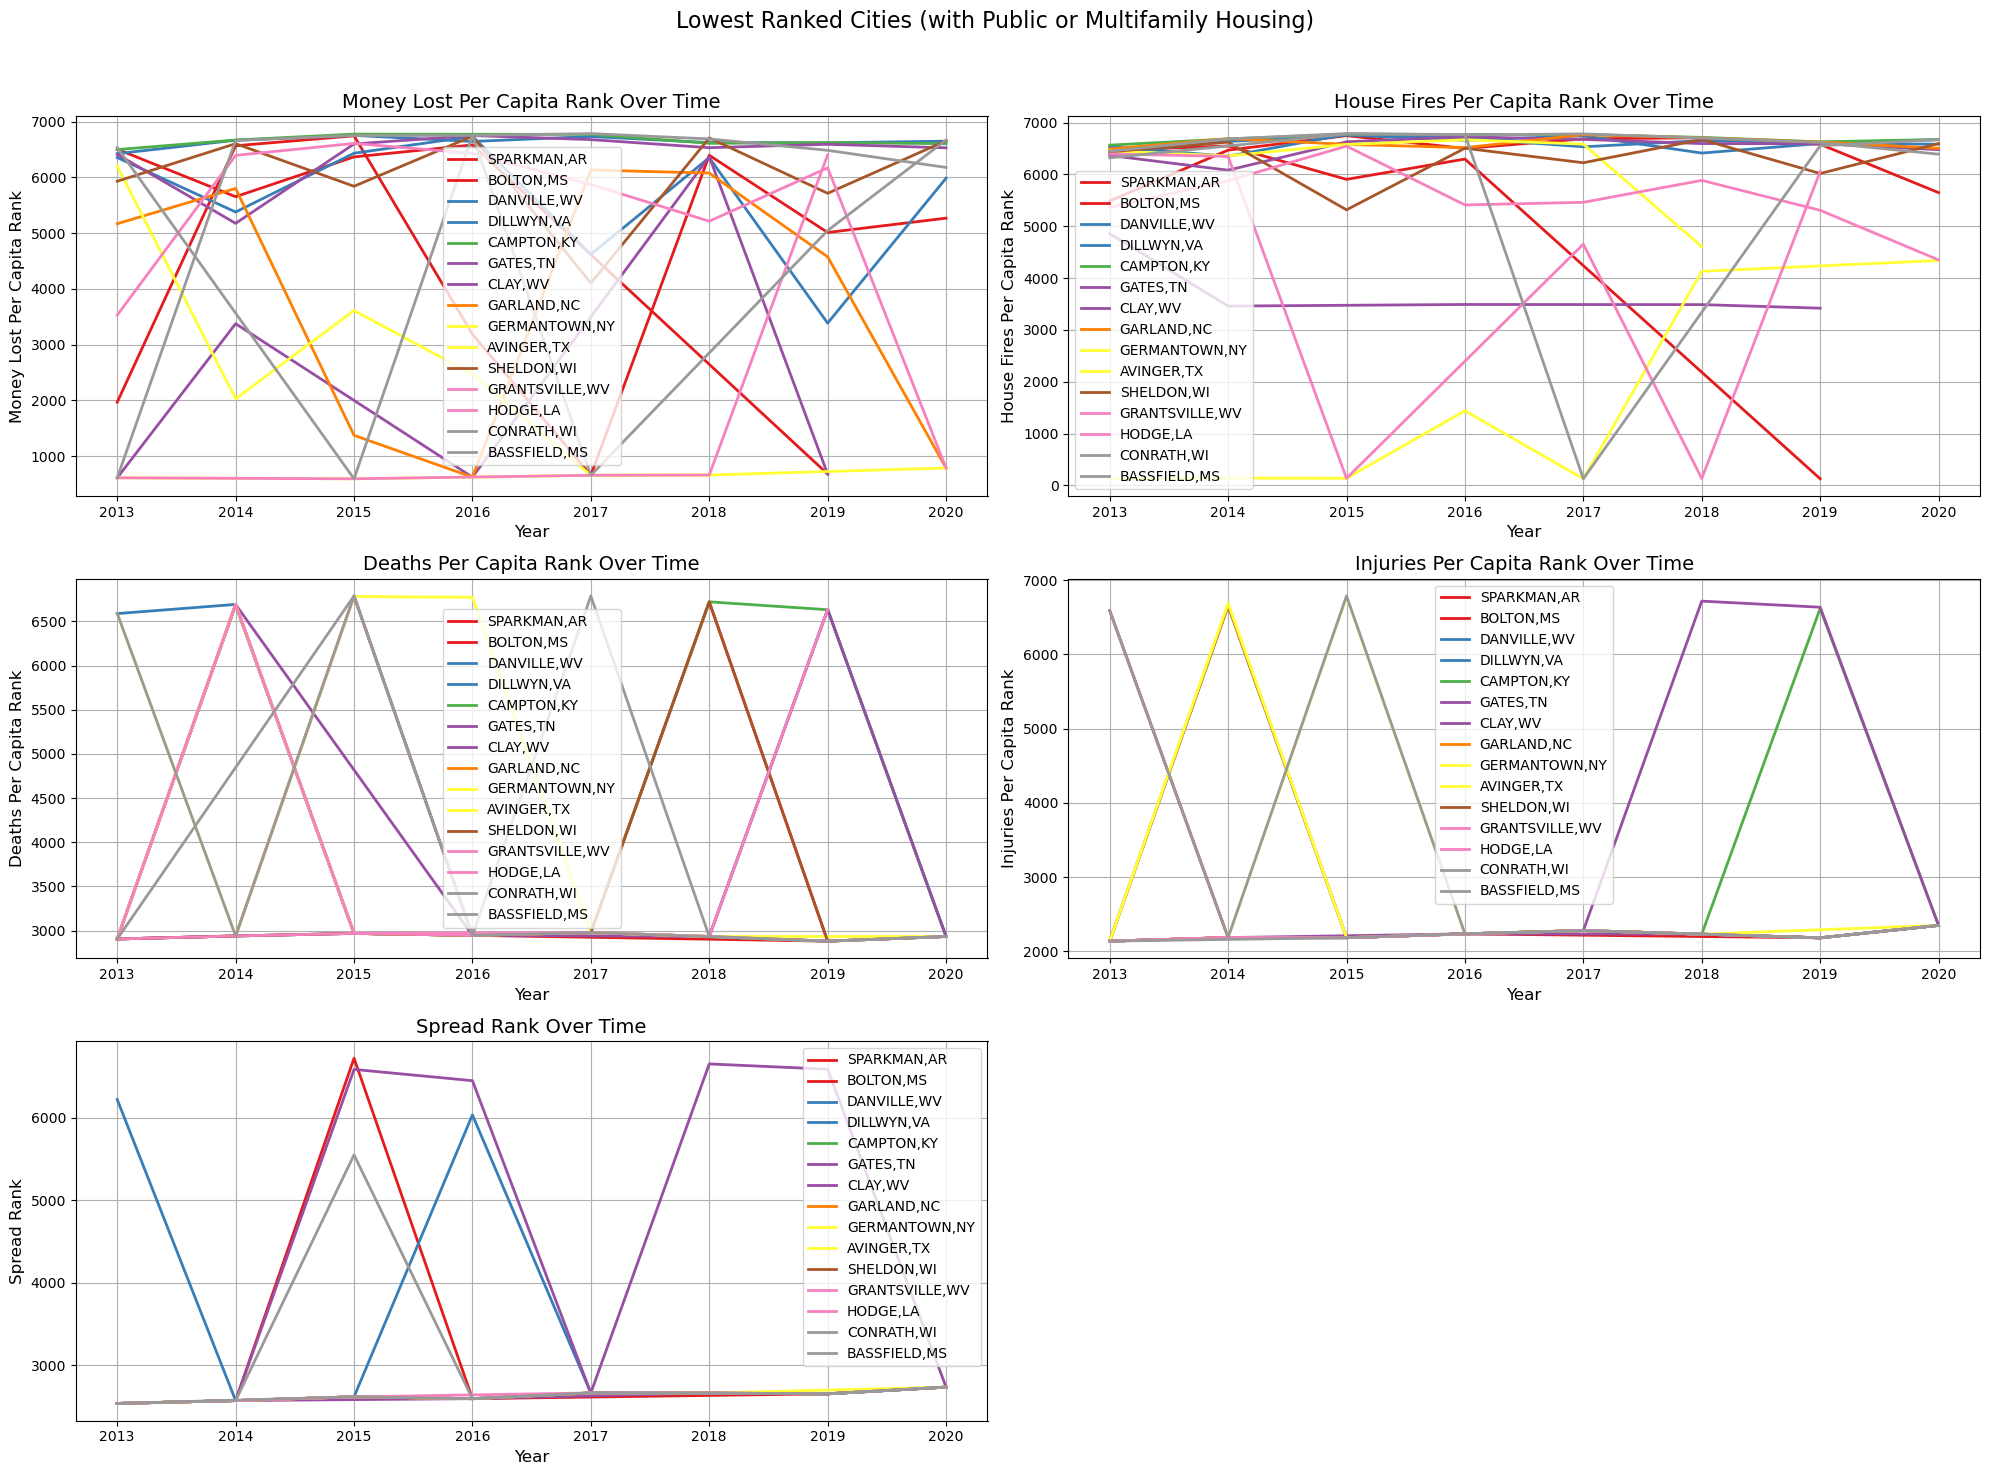

In [172]:
# List of cities you are interested in
cities = list(df.groupby(by='CITYSTATE').mean().sort_values(by='deaths_per_capita').tail(15).index)

# List of rankings you are interested in
rankings = ['money_lost_per_capita_rank', 'house_fires_per_capita_rank', 'deaths_per_capita_rank', 
            'injuries_per_capita_rank', 'spread_rank']

# Create a new figure for each ranking
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Flatten the axes array so we can iterate over it
axs = axs.flatten()

# Define a color palette
colors = plt.cm.Set1(np.linspace(0, 1, len(cities)))

# For each ranking
for i, rank in enumerate(rankings):
    # For each city
    for j, city in enumerate(cities):
        city_data = df[df['CITYSTATE'] == city]
        # Plot the ranking over time
        axs[i].plot(city_data['YEAR_x'], city_data[rank], label=city, linewidth=2, color=colors[j])
    
    axs[i].set_title(f'{rank.replace("_", " ").title()} Over Time', fontsize=14)
    axs[i].set_xlabel('Year', fontsize=12)
    axs[i].set_ylabel(rank.replace("_", " ").title(), fontsize=12)
    axs[i].legend(fontsize=10)
    axs[i].grid(True)

# Remove the unused subplot
fig.delaxes(axs[-1])

fig.suptitle('Lowest Ranked Cities (with Public or Multifamily Housing)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Apply tight layout with space for the super title
plt.show()


C:\Users\jackv\AppData\Local\Temp\ipykernel_18680\4121865888.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cities = list(df[df.POPULATION > 100000].groupby(by='CITYSTATE').mean().sort_values(by='deaths_per_capita').tail(15).index)


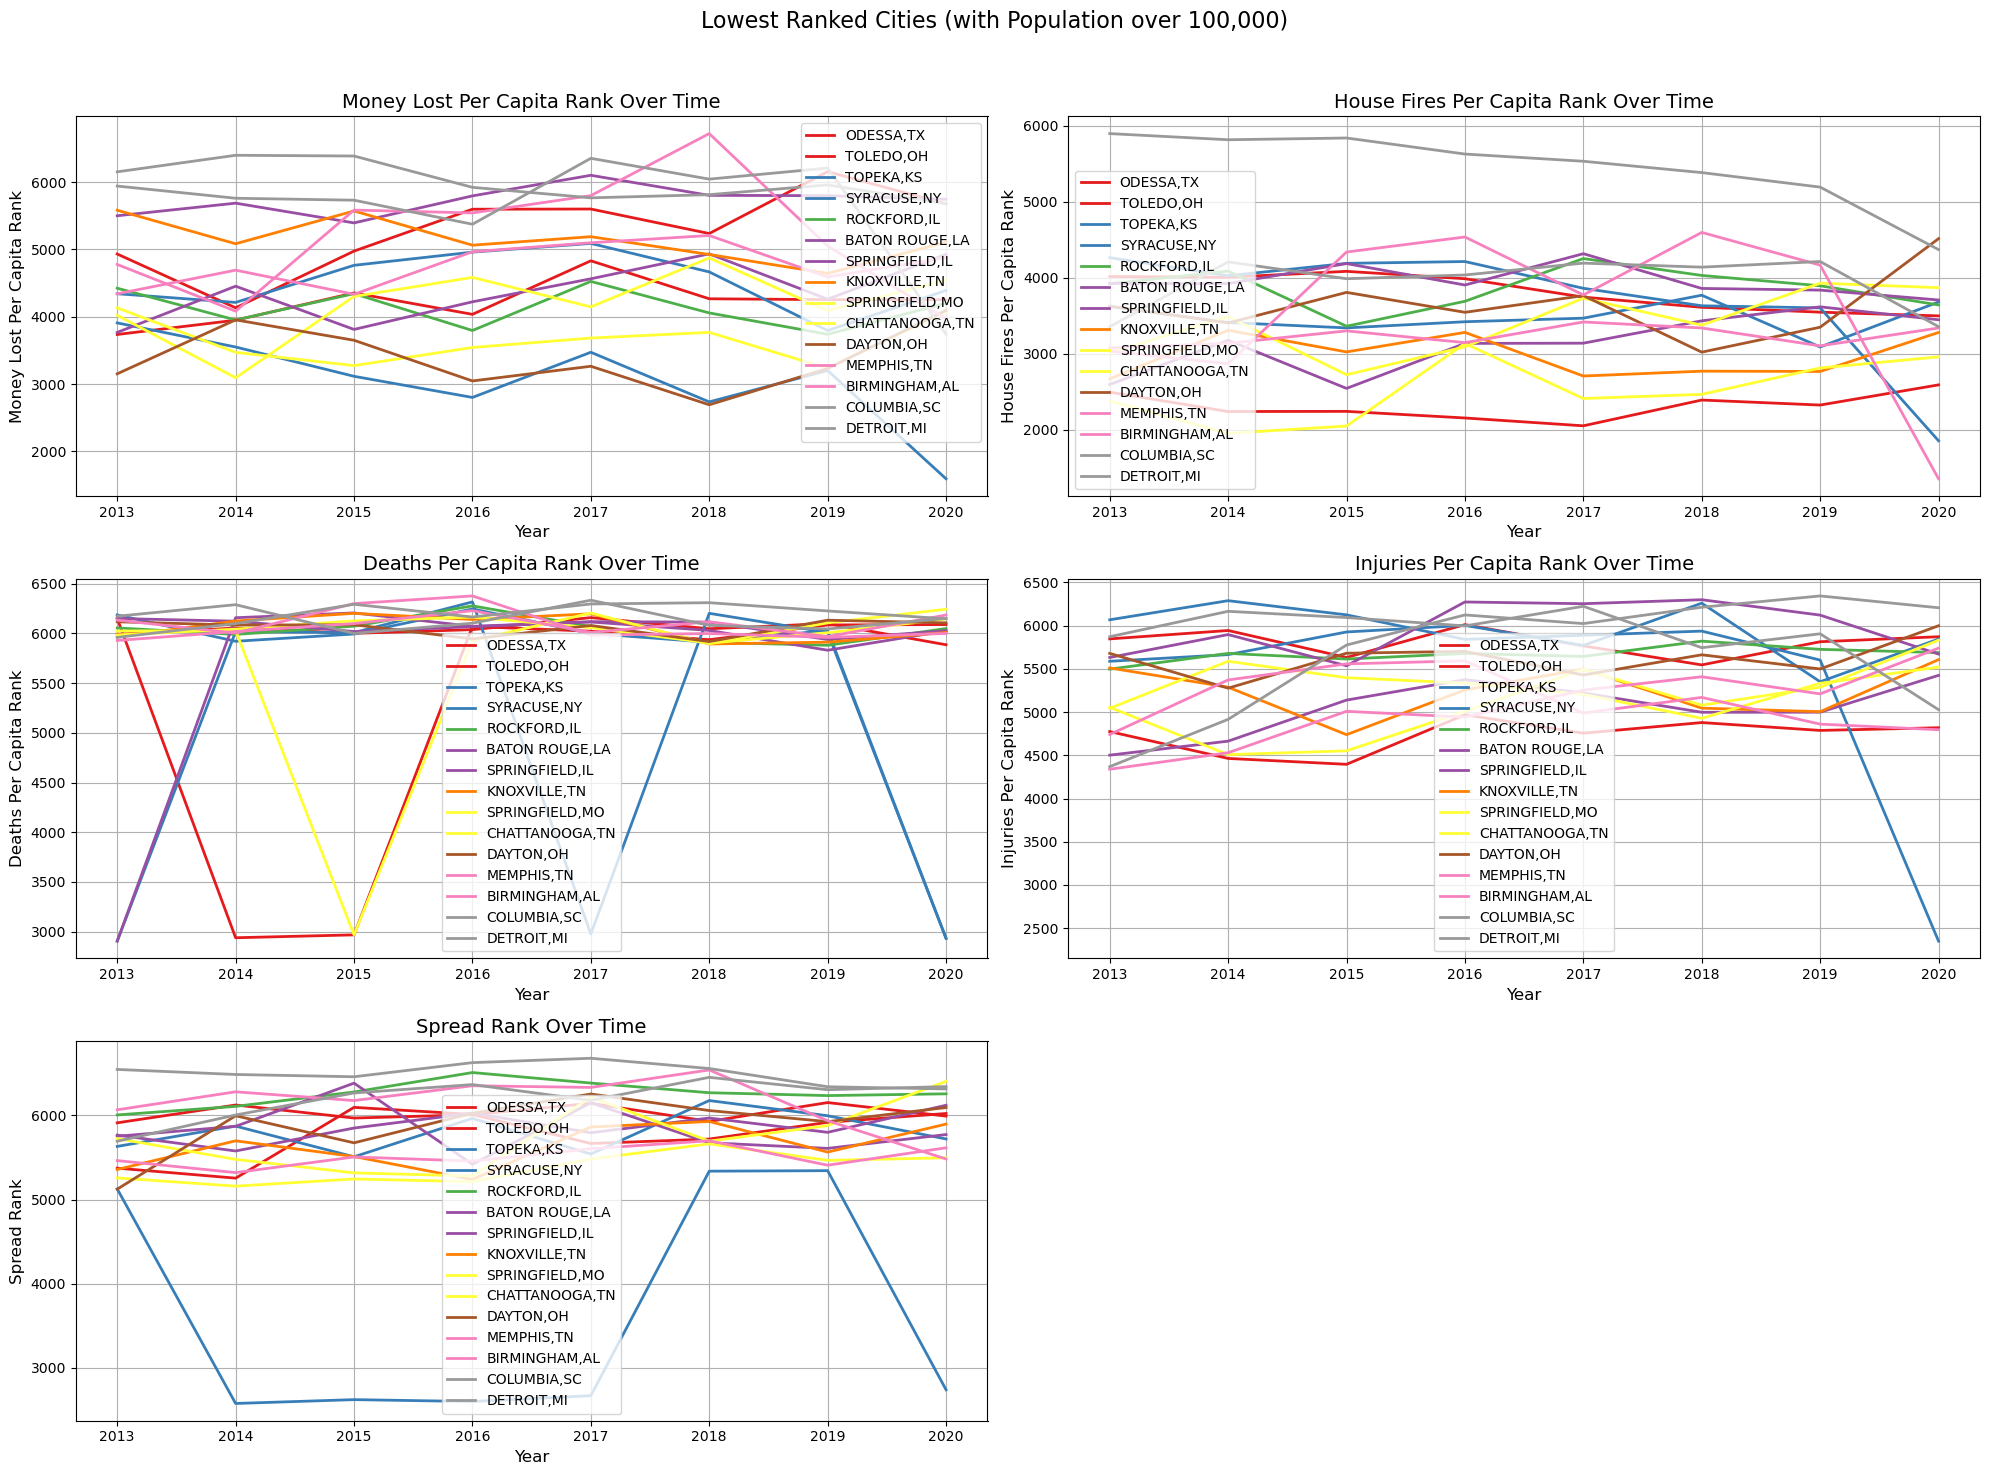

In [171]:
# List of cities you are interested in
cities = list(df[df.POPULATION > 100000].groupby(by='CITYSTATE').mean().sort_values(by='deaths_per_capita').tail(15).index)

# List of rankings you are interested in
rankings = ['money_lost_per_capita_rank', 'house_fires_per_capita_rank', 'deaths_per_capita_rank', 
            'injuries_per_capita_rank', 'spread_rank']

# Create a new figure for each ranking
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Flatten the axes array so we can iterate over it
axs = axs.flatten()

# Define a color palette
colors = plt.cm.Set1(np.linspace(0, 1, len(cities)))

# For each ranking
for i, rank in enumerate(rankings):
    # For each city
    for j, city in enumerate(cities):
        city_data = df[df['CITYSTATE'] == city]
        # Plot the ranking over time
        axs[i].plot(city_data['YEAR_x'], city_data[rank], label=city, linewidth=2, color=colors[j])
    
    axs[i].set_title(f'{rank.replace("_", " ").title()} Over Time', fontsize=14)
    axs[i].set_xlabel('Year', fontsize=12)
    axs[i].set_ylabel(rank.replace("_", " ").title(), fontsize=12)
    axs[i].legend(fontsize=10)
    axs[i].grid(True)

# Remove the unused subplot
fig.delaxes(axs[-1])

fig.suptitle('Lowest Ranked Cities (with Population over 100,000)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Apply tight layout with space for the super title
plt.show()


### Mathematically check stability over time

Coorelation coefficients between rankings.

<Axes: >

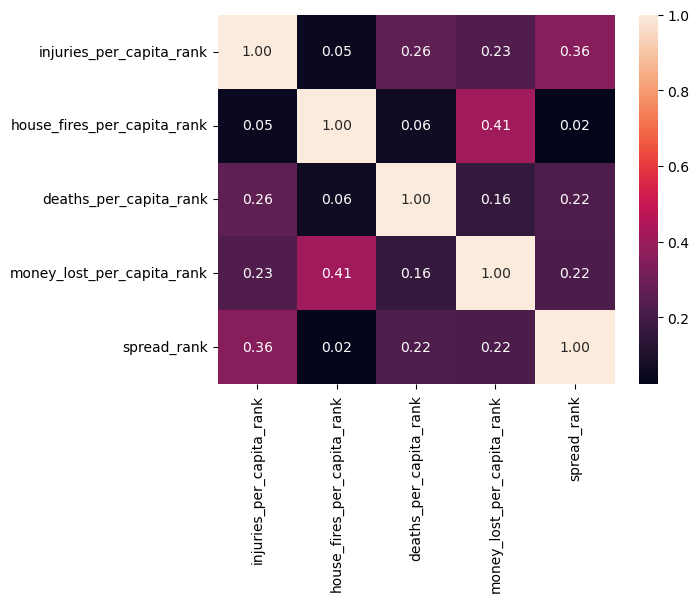

In [14]:
sns.heatmap(df.loc[:, ['injuries_per_capita_rank', 'house_fires_per_capita_rank', 'deaths_per_capita_rank', 
            'money_lost_per_capita_rank', 'spread_rank']].corr(), annot=True, fmt='.2f')

In [15]:
from scipy.stats import pearsonr

data = df.loc[:, ['injuries_per_capita_rank', 'house_fires_per_capita_rank', 
                  'deaths_per_capita_rank', 'money_lost_per_capita_rank']]

correlation_matrix = data.corr()
p_values = pd.DataFrame(index=correlation_matrix.columns, columns=correlation_matrix.columns)
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if col != row:
            p_value = pearsonr(data[row], data[col])[1]
            if p_value == 0:  
                p_value = np.finfo(float).tiny
            p_values.loc[row, col] = p_value
        else:
            p_values.loc[row, col] = np.nan

p_values.astype(float)


,injuries_per_capita_rank,house_fires_per_capita_rank,deaths_per_capita_rank,money_lost_per_capita_rank
injuries_per_capita_rank,NaN,4.643240e-30,2.225074e-308,2.225074e-308
house_fires_per_capita_rank,4.643240e-30,NaN,2.873586e-43,2.225074e-308
deaths_per_capita_rank,2.225074e-308,2.873586e-43,NaN,3.623381e-300
money_lost_per_capita_rank,2.225074e-308,2.225074e-308,3.623381e-300,NaN


Check standard deviation of rankings for a city (i.e. measure the variance between years for the same city)

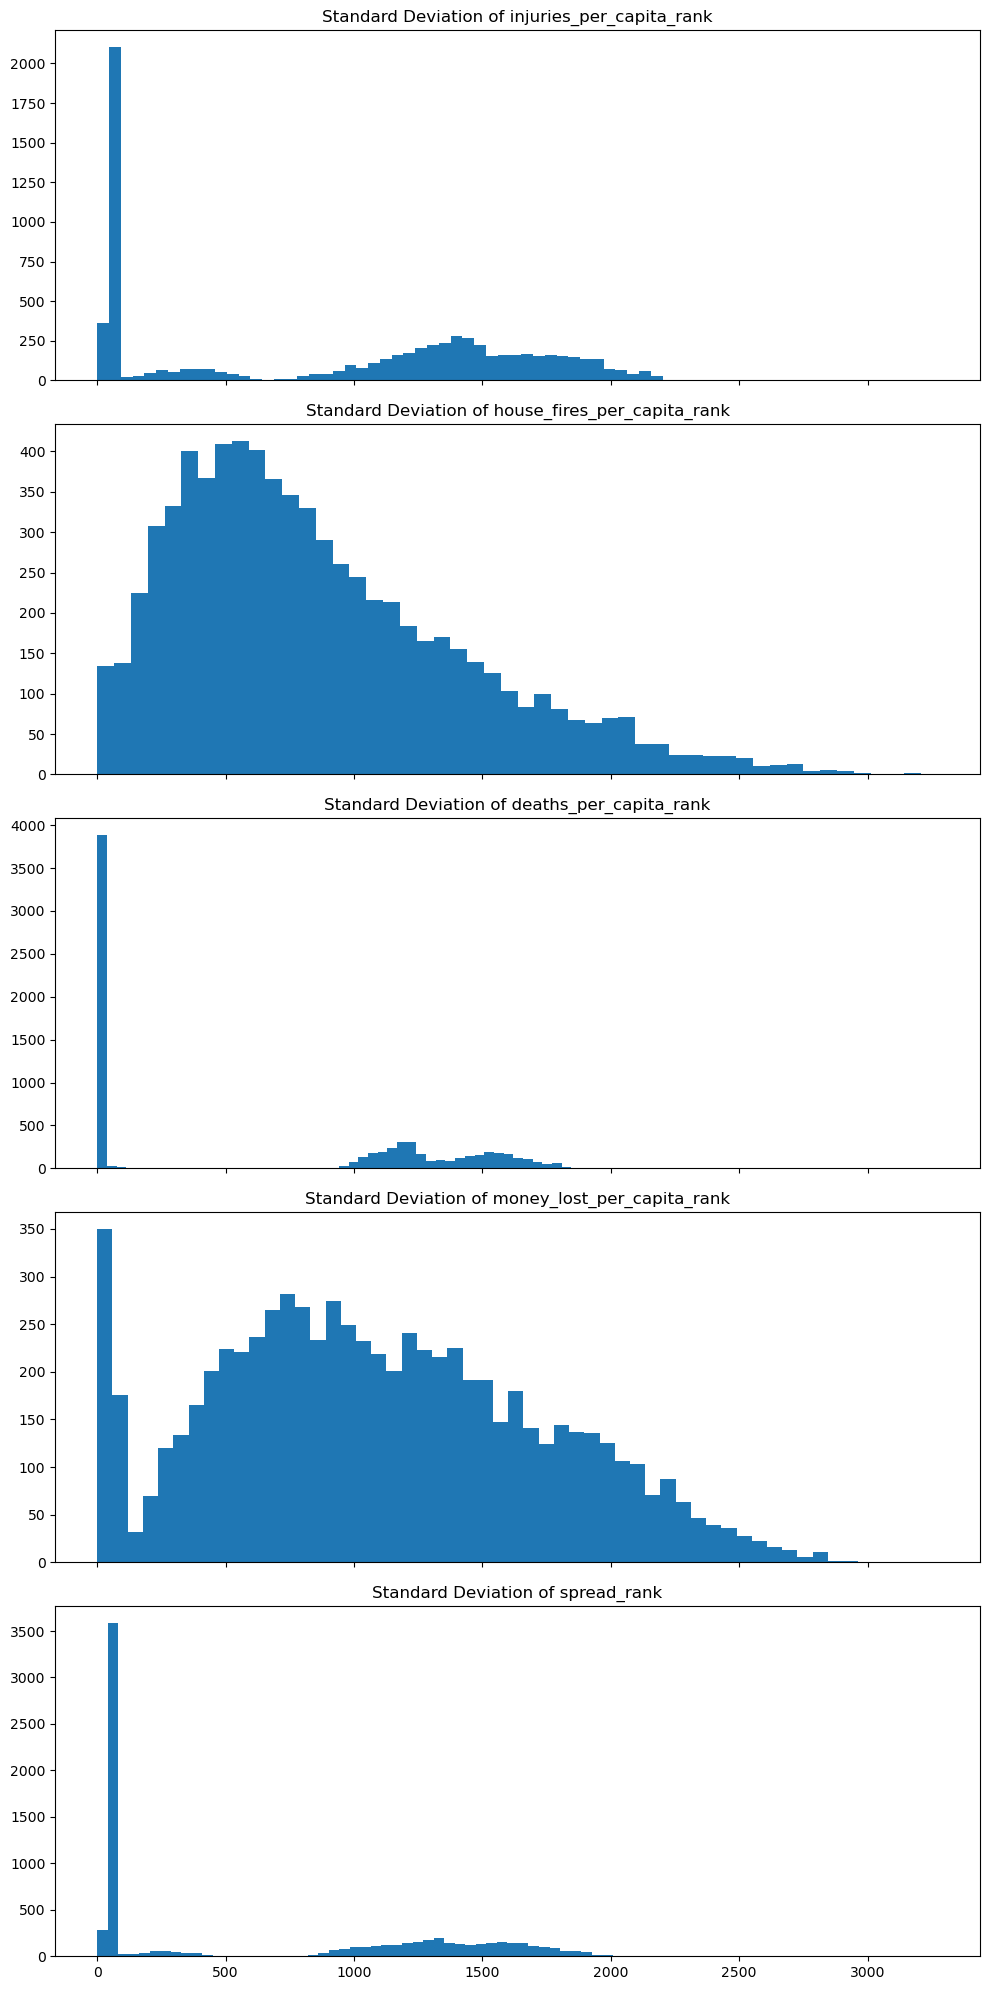

In [16]:
# Define rankings
rankings = ['injuries_per_capita_rank', 'house_fires_per_capita_rank', 'deaths_per_capita_rank', 
            'money_lost_per_capita_rank', 'spread_rank']

# Initialize plot with shared x axis
fig, axs = plt.subplots(len(rankings), figsize=(10, 20), sharex=True)

# Generate histograms for each ranking
for i, rank in enumerate(rankings):
    std_devs = df.groupby('CITYSTATE')[rank].apply(np.std)
    axs[i].hist(std_devs, bins=50)
    axs[i].set_title(f'Standard Deviation of {rank}')

plt.tight_layout()
plt.show()


In [17]:
print('Median std (by city)')
for rank in rankings:
    print(rank, ':', df.groupby(by='CITYSTATE')[rank].apply(np.std).median())

print()
print('Mean std (by city)')
for rank in rankings:
    print(rank, ':', df.groupby(by='CITYSTATE')[rank].apply(np.std).mean())

Median std (by city)
injuries_per_capita_rank : 1130.2183477036197
house_fires_per_capita_rank : 741.2906338466616
deaths_per_capita_rank : 31.285225045098347
money_lost_per_capita_rank : 1036.058585898932
spread_rank : 61.646374672028216

Mean std (by city)
injuries_per_capita_rank : 906.8152759586853
house_fires_per_capita_rank : 864.5636586679393
deaths_per_capita_rank : 627.2216373356503
money_lost_per_capita_rank : 1092.8390574795892
spread_rank : 625.1502063586352


### Ranking large cities

Top and bottom cities below some population threshold.

In [23]:
big_cities = df[df.POPULATION > 100000]

10 best cities for house fires per capita

In [41]:
big_cities.groupby(by=['CITYSTATE'])['house_fires_per_capita'] \
    .apply(np.mean) \
    .sort_values() \
    .head(15)

CITYSTATE
OYSTER BAY,NY        0.000014
HUNTINGTON,NY        0.000037
HAYWARD,CA           0.000039
MORENO VALLEY,CA     0.000044
LAKEWOOD,NJ          0.000045
SANTA CLARA,CA       0.000051
RIALTO,CA            0.000080
SAN JOSE,CA          0.000089
GLENDALE,AZ          0.000092
EDISON,NJ            0.000093
SANTA CLARITA,CA     0.000099
PEMBROKE PINES,FL    0.000109
CORONA,CA            0.000114
NORWALK,CA           0.000119
SMITHTOWN,NY         0.000120
Name: house_fires_per_capita, dtype: float64

10 worst cities for house fires per capita

In [42]:
big_cities.groupby(by=['CITYSTATE'])['house_fires_per_capita'] \
    .apply(np.mean) \
    .sort_values() \
    .tail(15)

CITYSTATE
DAYTON,OH              0.001607
LITTLE ROCK,AR         0.001607
CLEVELAND,OH           0.001690
ST. LOUIS,MO           0.001691
SYRACUSE,NY            0.001739
TOLEDO,OH              0.001740
BIRMINGHAM,AL          0.001741
ROCKFORD,IL            0.001786
BATON ROUGE,LA         0.001860
COLUMBIA,SC            0.001865
CINCINNATI,OH          0.001874
FAYETTEVILLE,NC        0.001935
NORTH CHARLESTON,SC    0.002070
ROCHESTER,NY           0.002503
DETROIT,MI             0.004618
Name: house_fires_per_capita, dtype: float64

10 best cities for deaths from fire per capita

In [43]:
big_cities.groupby(by=['CITYSTATE'])['deaths_per_capita'] \
    .apply(np.mean) \
    .sort_values() \
    .head(15)

CITYSTATE
HESPERIA,CA         0.0
HUNTINGTON,NY       0.0
CARLSBAD,CA         0.0
CARY,NC             0.0
HILLSBORO,OR        0.0
HIALEAH,FL          0.0
SMITHTOWN,NY        0.0
OYSTER BAY,NY       0.0
SCOTTSDALE,AZ       0.0
SANTA CLARA,CA      0.0
SANDY SPRINGS,GA    0.0
ORANGE,CA           0.0
PALMDALE,CA         0.0
GLENDALE,CA         0.0
DALY CITY,CA        0.0
Name: deaths_per_capita, dtype: float64

10 worst cities for deaths from fire per capita

In [44]:
big_cities.groupby(by=['CITYSTATE'])['deaths_per_capita'] \
    .apply(np.mean) \
    .sort_values() \
    .tail(15)

CITYSTATE
ODESSA,TX         0.000017
TOLEDO,OH         0.000018
TOPEKA,KS         0.000018
SYRACUSE,NY       0.000019
ROCKFORD,IL       0.000019
BATON ROUGE,LA    0.000019
SPRINGFIELD,IL    0.000020
KNOXVILLE,TN      0.000020
SPRINGFIELD,MO    0.000020
CHATTANOOGA,TN    0.000021
DAYTON,OH         0.000022
MEMPHIS,TN        0.000022
BIRMINGHAM,AL     0.000028
COLUMBIA,SC       0.000035
DETROIT,MI        0.000039
Name: deaths_per_capita, dtype: float64

Looking just at the most recent year, 2020, cities like Detroit and Columbia, SC continue to be ranked low.

In [49]:
big_cities[big_cities.YEAR_x == 2020].sort_values(by='deaths_per_capita').tail(10)

,CITYSTATE_x,YEAR_x,SUM_PROP_LOSS,SUM_CONT_LOSS,SUM_OTH_DEATH,SUM_FF_DEATH,SUM_OTH_INJ,SUM_FF_INJ,LOSS_SUPPORT,CITYSTATE_YEAR,CITYSTATE_y,YEAR_y,SUM_SPREAD,SPREAD_SUPPORT,CITYSTATE_x.1,YEAR_x.1,TOTAL_INCIDENT_COUNT,CITYSTATE_y.1,YEAR_y.1,COUNT_111,COUNT_113,COUNT_131,COUNT_151,COUNT_142,CITYSTATE,POPULATION,sum_loss,sum_death,sum_injury,money_lost_per_capita,deaths_per_capita,injuries_per_capita,fires_per_capita,sum_111_per_fire,sum_113_per_fire,sum_131_per_fire,sum_151_per_fire,sum_142_per_fire,sum_secondary_fires_per_fire,house_fires_per_capita,cooking_fires_per_capita,injuries_per_capita_rank,house_fires_per_capita_rank,deaths_per_capita_rank,money_lost_per_capita_rank,spread_rank
48965,"VACAVILLE,CA",2020,5199717.0,961612.0,3.0,0.0,1.0,4.0,305,"VACAVILLE,CA,2020","VACAVILLE,CA",2020,16,291,"VACAVILLE,CA",2020,289,"VACAVILLE,CA",2020,30,12,35,23,23,"VACAVILLE,CA",102675,6161329.0,3.0,5.0,60.008074,0.000029,0.000049,0.002815,0.103806,0.041522,0.121107,0.079585,0.079585,0.055363,0.000292,0.000117,5194.0,1028.0,6107.0,5120.0,6455.0
767,"ALLENTOWN,PA",2020,0.0,0.0,4.0,0.0,0.0,0.0,171,"ALLENTOWN,PA,2020","ALLENTOWN,PA",2020,0,171,"ALLENTOWN,PA",2020,171,"ALLENTOWN,PA",2020,83,20,19,6,8,"ALLENTOWN,PA",126092,0.0,4.0,0.0,0.000000,0.000032,0.000000,0.001356,0.485380,0.116959,0.111111,0.035088,0.046784,0.000000,0.000658,0.000159,2350.5,2151.0,6118.0,785.5,2737.0
27522,"LITTLE ROCK,AR",2020,12101887.0,3210098.0,7.0,0.0,5.0,13.0,1463,"LITTLE ROCK,AR,2020","LITTLE ROCK,AR",2020,24,1440,"LITTLE ROCK,AR",2020,1439,"LITTLE ROCK,AR",2020,378,67,219,72,134,"LITTLE ROCK,AR",202514,15311985.0,7.0,18.0,75.609513,0.000035,0.000089,0.007106,0.262682,0.046560,0.152189,0.050035,0.093120,0.016678,0.001867,0.000331,5562.0,4148.0,6135.0,5385.0,5938.0
45637,"SPRINGFIELD,MO",2020,4101690.0,769148.0,6.0,0.0,14.0,0.0,993,"SPRINGFIELD,MO,2020","SPRINGFIELD,MO",2020,2,991,"SPRINGFIELD,MO",2020,991,"SPRINGFIELD,MO",2020,272,47,114,36,280,"SPRINGFIELD,MO",169767,4870838.0,6.0,14.0,28.691312,0.000035,0.000082,0.005837,0.274470,0.047427,0.115035,0.036327,0.282543,0.002018,0.001602,0.000277,5520.0,3869.0,6143.0,4076.0,5496.0
13013,"DETROIT,MI",2020,47795334.0,16243681.0,23.0,0.0,125.0,35.0,3403,"DETROIT,MI,2020","DETROIT,MI",2020,136,3268,"DETROIT,MI",2020,3268,"DETROIT,MI",2020,1339,273,639,80,509,"DETROIT,MI",639614,64039015.0,23.0,160.0,100.121347,0.000036,0.000250,0.005109,0.409731,0.083537,0.195532,0.024480,0.155753,0.041616,0.002093,0.000427,6207.0,4370.0,6146.0,5678.0,6343.0
10469,"COLUMBIA,SC",2020,2287542.0,783345.0,5.0,0.0,4.0,1.0,520,"COLUMBIA,SC,2020","COLUMBIA,SC",2020,19,502,"COLUMBIA,SC",2020,501,"COLUMBIA,SC",2020,168,75,85,36,24,"COLUMBIA,SC",137300,3070887.0,5.0,5.0,22.366256,0.000036,0.000036,0.003649,0.335329,0.149701,0.169661,0.071856,0.047904,0.037924,0.001224,0.000546,5028.0,3356.0,6149.0,3740.0,6315.0
30583,"MEMPHIS,TN",2020,23151018.0,8126402.0,26.0,0.0,48.0,25.0,3576,"MEMPHIS,TN,2020","MEMPHIS,TN",2020,23,3553,"MEMPHIS,TN",2020,3553,"MEMPHIS,TN",2020,768,354,859,114,508,"MEMPHIS,TN",632207,31277420.0,26.0,73.0,49.473385,0.000041,0.000115,0.005620,0.216155,0.099634,0.241768,0.032086,0.142978,0.006473,0.001215,0.000560,5740.0,3339.0,6184.0,4878.0,5615.0
26273,"LANSING,MI",2020,1311950.0,866255.0,5.0,0.0,4.0,5.0,435,"LANSING,MI,2020","LANSING,MI",2020,0,435,"LANSING,MI",2020,435,"LANSING,MI",2020,87,57,51,31,37,"LANSING,MI",112954,2178205.0,5.0,9.0,19.284001,0.000044,0.000080,0.003851,0.200000,0.131034,0.117241,0.071264,0.085057,0.000000,0.000770,0.000505,5499.0,2435.0,6198.0,3555.0,2737.0
19148,"GRAND RAPIDS,MI",2020,7573848.0,2083941.0,9.0,0.0,10.0,13.0,801,"GRAND RAPIDS,MI,2020","GRAND RAPIDS,MI",2020,20,781,"GRAND RAPIDS,MI",2020,781,"GRAND RAPIDS,MI",2020,212,171,128,32,67,"GRAND RAPIDS,MI",198487,9657789.0,9.0,23.0,48.657035,0.000045,0.000116,0.003935,0.271447,0.218950,0.163892,0.040973,0.085787,0.025608,0.001068,0.000862,5743.0,3064.0,6203.0,4852.0,6140.0
8808,"CHATTANOOGA,TN",2020,5409100.0,1682801.0,10.0,0.0,15.0,9.0,893,"CHATTAN

In [50]:
big_cities[big_cities.YEAR_x == 2020].sort_values(by='house_fires_per_capita').tail(10)

,CITYSTATE_x,YEAR_x,SUM_PROP_LOSS,SUM_CONT_LOSS,SUM_OTH_DEATH,SUM_FF_DEATH,SUM_OTH_INJ,SUM_FF_INJ,LOSS_SUPPORT,CITYSTATE_YEAR,CITYSTATE_y,YEAR_y,SUM_SPREAD,SPREAD_SUPPORT,CITYSTATE_x.1,YEAR_x.1,TOTAL_INCIDENT_COUNT,CITYSTATE_y.1,YEAR_y.1,COUNT_111,COUNT_113,COUNT_131,COUNT_151,COUNT_142,CITYSTATE,POPULATION,sum_loss,sum_death,sum_injury,money_lost_per_capita,deaths_per_capita,injuries_per_capita,fires_per_capita,sum_111_per_fire,sum_113_per_fire,sum_131_per_fire,sum_151_per_fire,sum_142_per_fire,sum_secondary_fires_per_fire,house_fires_per_capita,cooking_fires_per_capita,injuries_per_capita_rank,house_fires_per_capita_rank,deaths_per_capita_rank,money_lost_per_capita_rank,spread_rank
9785,"CLEVELAND,OH",2020,4366174.0,962330.0,8.0,0.0,36.0,6.0,1808,"CLEVELAND,OH,2020","CLEVELAND,OH",2020,63,1758,"CLEVELAND,OH",2020,1746,"CLEVELAND,OH",2020,563,113,338,75,344,"CLEVELAND,OH",373091,5328504.0,8.0,42.0,14.282049,0.000021,0.000113,0.004680,0.322451,0.064719,0.193585,0.042955,0.197022,0.036082,0.001509,0.000303,5724.0,3744.0,6060.0,3191.0,6292.0
34922,"NORTH CHARLESTON,SC",2020,9143518.0,2060370.0,0.0,0.0,15.0,3.0,703,"NORTH CHARLESTON,SC,2020","NORTH CHARLESTON,SC",2020,17,686,"NORTH CHARLESTON,SC",2020,686,"NORTH CHARLESTON,SC",2020,174,74,113,46,158,"NORTH CHARLESTON,SC",115113,11203888.0,0.0,18.0,97.329476,0.000000,0.000156,0.005959,0.253644,0.107872,0.164723,0.067055,0.230321,0.024781,0.001512,0.000643,5934.0,3753.0,2933.0,5650.0,6126.0
9303,"CINCINNATI,OH",2020,8813466.0,1762006.0,1.0,0.0,20.0,4.0,1850,"CINCINNATI,OH,2020","CINCINNATI,OH",2020,16,1834,"CINCINNATI,OH",2020,1834,"CINCINNATI,OH",2020,471,240,277,104,130,"CINCINNATI,OH",310242,10575472.0,1.0,24.0,34.087815,0.000003,0.000077,0.005912,0.256816,0.130862,0.151036,0.056707,0.070883,0.008724,0.001518,0.000774,5476.0,3767.0,5882.0,4333.0,5692.0
48593,"TYLER,TX",2020,4515952.0,1160960.0,0.0,0.0,9.0,1.0,721,"TYLER,TX,2020","TYLER,TX",2020,0,721,"TYLER,TX",2020,721,"TYLER,TX",2020,166,41,93,55,58,"TYLER,TX",105735,5676912.0,0.0,10.0,53.689999,0.000000,0.000095,0.006819,0.230236,0.056865,0.128988,0.076283,0.080444,0.000000,0.001570,0.000388,5603.0,3839.0,2933.0,4994.0,2737.0
37872,"PEORIA,IL",2020,4910337.0,2821010.0,0.0,0.0,40.0,16.0,649,"PEORIA,IL,2020","PEORIA,IL",2020,37,612,"PEORIA,IL",2020,612,"PEORIA,IL",2020,178,96,72,60,59,"PEORIA,IL",113173,7731347.0,0.0,56.0,68.314412,0.000000,0.000495,0.005408,0.290850,0.156863,0.117647,0.098039,0.096405,0.060458,0.001573,0.000848,6464.0,3843.0,2933.0,5271.0,6492.0
45637,"SPRINGFIELD,MO",2020,4101690.0,769148.0,6.0,0.0,14.0,0.0,993,"SPRINGFIELD,MO,2020","SPRINGFIELD,MO",2020,2,991,"SPRINGFIELD,MO",2020,991,"SPRINGFIELD,MO",2020,272,47,114,36,280,"SPRINGFIELD,MO",169767,4870838.0,6.0,14.0,28.691312,0.000035,0.000082,0.005837,0.274470,0.047427,0.115035,0.036327,0.282543,0.002018,0.001602,0.000277,5520.0,3869.0,6143.0,4076.0,5496.0
16328,"FAYETTEVILLE,NC",2020,4096803.0,953177.0,5.0,0.0,27.0,3.0,965,"FAYETTEVILLE,NC,2020","FAYETTEVILLE,NC",2020,17,948,"FAYETTEVILLE,NC",2020,948,"FAYETTEVILLE,NC",2020,366,106,81,68,92,"FAYETTEVILLE,NC",208871,5049980.0,5.0,30.0,24.177507,0.000024,0.000144,0.004539,0.386076,0.111814,0.085443,0.071730,0.097046,0.017932,0.001752,0.000507,5884.0,4023.0,6076.0,3863.0,5972.0
27522,"LITTLE ROCK,AR",2020,12101887.0,3210098.0,7.0,0.0,5.0,13.0,1463,"LITTLE ROCK,AR,2020","LITTLE ROCK,AR",2020,24,1440,"LITTLE ROCK,AR",2020,1439,"LITTLE ROCK,AR",2020,378,67,219,72,134,"LITTLE ROCK,AR",202514,15311985.0,7.0,18.0,75.609513,0.000035,0.000089,0.007106,0.262682,0.046560,0.152189,0.050035,0.093120,0.016678,0.001867,0.000331,5562.0,4148.0,6135.0,5385.0,5938.0
13013,"DETROIT,MI",2020,47795334.0,16243681.0,23.0,0.0,125.0,35.0,3403,"DETROIT,MI,2020","DETROIT,MI",2020,136,3268,"DETROIT,MI",2020,3268,"DETROIT,MI",2020,1339,273,639,80,509,"DETROIT,MI",639614,64039015.0,23.0,160.0,100.121347,0.000036,0.000250,0.005109,0.409731,0.083537,0.195532,0.024480,0.155753,0.041616,0.002093,0.000427,6207.0,4370.0,6146.0,5678.0,6343.0
124

### Cities that score low across multiple metrics

In [46]:
df.sample()

,CITYSTATE_x,YEAR_x,SUM_PROP_LOSS,SUM_CONT_LOSS,SUM_OTH_DEATH,SUM_FF_DEATH,SUM_OTH_INJ,SUM_FF_INJ,LOSS_SUPPORT,CITYSTATE_YEAR,CITYSTATE_y,YEAR_y,SUM_SPREAD,SPREAD_SUPPORT,CITYSTATE_x.1,YEAR_x.1,TOTAL_INCIDENT_COUNT,CITYSTATE_y.1,YEAR_y.1,COUNT_111,COUNT_113,COUNT_131,COUNT_151,COUNT_142,CITYSTATE,POPULATION,sum_loss,sum_death,sum_injury,money_lost_per_capita,deaths_per_capita,injuries_per_capita,fires_per_capita,sum_111_per_fire,sum_113_per_fire,sum_131_per_fire,sum_151_per_fire,sum_142_per_fire,sum_secondary_fires_per_fire,house_fires_per_capita,cooking_fires_per_capita,injuries_per_capita_rank,house_fires_per_capita_rank,deaths_per_capita_rank,money_lost_per_capita_rank,spread_rank
11131,"CORSICANA,TX",2020,917397.0,181650.0,1.0,0.0,0.0,1.0,123,"CORSICANA,TX,2020","CORSICANA,TX",2020,5,118,"CORSICANA,TX",2020,118,"CORSICANA,TX",2020,28,8,13,6,35,"CORSICANA,TX",24825,1099047.0,1.0,1.0,44.271782,0.00004,0.00004,0.004753,0.237288,0.067797,0.110169,0.050847,0.29661,0.042373,0.001128,0.000322,5089.0,3182.0,6172.0,4708.0,6357.0


Bottom 25th percentile on multiple metrics.

In [54]:
df.describe()[['deaths_per_capita_rank', 'house_fires_per_capita_rank']]

,deaths_per_capita_rank,house_fires_per_capita_rank
count,53680.000000,53680.000000
mean,3355.852366,3355.852366
std,1114.672915,1937.568810
min,2880.500000,128.000000
25%,2933.000000,1678.000000
50%,2939.000000,3355.500000
75%,2968.000000,5033.000000
max,6789.000000,6789.000000


For cities above 100,000 population, Detroit is the only one that is ranked below 25th percentile on deaths and fires per capita.

In [56]:
df[
    (df.deaths_per_capita_rank > 2968) &
    (df.house_fires_per_capita_rank > 5033) &
    (df.POPULATION > 100000)
]

,CITYSTATE_x,YEAR_x,SUM_PROP_LOSS,SUM_CONT_LOSS,SUM_OTH_DEATH,SUM_FF_DEATH,SUM_OTH_INJ,SUM_FF_INJ,LOSS_SUPPORT,CITYSTATE_YEAR,CITYSTATE_y,YEAR_y,SUM_SPREAD,SPREAD_SUPPORT,CITYSTATE_x.1,YEAR_x.1,TOTAL_INCIDENT_COUNT,CITYSTATE_y.1,YEAR_y.1,COUNT_111,COUNT_113,COUNT_131,COUNT_151,COUNT_142,CITYSTATE,POPULATION,sum_loss,sum_death,sum_injury,money_lost_per_capita,deaths_per_capita,injuries_per_capita,fires_per_capita,sum_111_per_fire,sum_113_per_fire,sum_131_per_fire,sum_151_per_fire,sum_142_per_fire,sum_secondary_fires_per_fire,house_fires_per_capita,cooking_fires_per_capita,injuries_per_capita_rank,house_fires_per_capita_rank,deaths_per_capita_rank,money_lost_per_capita_rank,spread_rank
13006,"DETROIT,MI",2013,123484666.0,37935762.0,10.0,0.0,10.0,1.0,6970,"DETROIT,MI,2013","DETROIT,MI",2013,129,6846,"DETROIT,MI",2013,6844,"DETROIT,MI",2013,4131,189,27,15,525,"DETROIT,MI",639614,161420428.0,10.0,11.0,252.371630,0.000016,0.000017,0.010700,0.603594,0.027615,0.003945,0.002192,0.076710,0.018849,0.006459,0.000295,4369.0,5896.0,5959.0,6151.0,5693.0
13007,"DETROIT,MI",2014,198513474.0,29752700.0,15.0,0.0,31.0,5.0,6901,"DETROIT,MI,2014","DETROIT,MI",2014,191,6716,"DETROIT,MI",2014,6712,"DETROIT,MI",2014,3710,228,27,22,540,"DETROIT,MI",639614,228266174.0,15.0,36.0,356.881141,0.000023,0.000056,0.010494,0.552741,0.033969,0.004023,0.003278,0.080453,0.028456,0.005800,0.000356,4916.0,5815.0,6098.0,6397.0,6005.0
13008,"DETROIT,MI",2015,168241252.0,22086180.0,25.0,0.0,100.0,2.0,6641,"DETROIT,MI,2015","DETROIT,MI",2015,229,6422,"DETROIT,MI",2015,6417,"DETROIT,MI",2015,3411,247,53,30,493,"DETROIT,MI",639614,190327432.0,25.0,102.0,297.566082,0.000039,0.000159,0.010033,0.531557,0.038492,0.008259,0.004675,0.076827,0.035686,0.005333,0.000386,5776.0,5838.0,6292.0,6386.0,6267.0
13009,"DETROIT,MI",2016,71715968.0,21592258.0,19.0,0.0,94.0,55.0,6357,"DETROIT,MI,2016","DETROIT,MI",2016,257,6104,"DETROIT,MI",2016,6103,"DETROIT,MI",2016,3021,321,649,51,631,"DETROIT,MI",639614,93308226.0,19.0,149.0,145.882088,0.000030,0.000233,0.009542,0.495002,0.052597,0.106341,0.008357,0.103392,0.042110,0.004723,0.000502,6124.0,5627.0,6164.0,5921.0,6367.0
13010,"DETROIT,MI",2017,55941552.0,18596206.0,26.0,1.0,84.0,38.0,6187,"DETROIT,MI,2017","DETROIT,MI",2017,178,6009,"DETROIT,MI",2017,6009,"DETROIT,MI",2017,2794,414,1168,97,779,"DETROIT,MI",639614,74537758.0,27.0,122.0,116.535532,0.000042,0.000191,0.009395,0.464969,0.068897,0.194375,0.016142,0.129639,0.029622,0.004368,0.000647,6024.0,5532.0,6295.0,5765.0,6179.0
13011,"DETROIT,MI",2018,67594320.0,19770880.0,39.0,0.0,103.0,84.0,6178,"DETROIT,MI,2018","DETROIT,MI",2018,311,5869,"DETROIT,MI",2018,5868,"DETROIT,MI",2018,2774,427,1209,101,759,"DETROIT,MI",639614,87365200.0,39.0,187.0,136.590506,0.000061,0.000292,0.009174,0.472733,0.072768,0.206033,0.017212,0.129346,0.052999,0.004337,0.000668,6213.0,5383.0,6308.0,5812.0,6453.0
13012,"DETROIT,MI",2019,82788443.0,31277390.0,43.0,0.0,179.0,132.0,5630,"DETROIT,MI,2019","DETROIT,MI",2019,241,5389,"DETROIT,MI",2019,5389,"DETROIT,MI",2019,2451,398,1102,127,763,"DETROIT,MI",639614,114065833.0,43.0,311.0,178.335423,0.000067,0.000486,0.008425,0.454815,0.073854,0.204491,0.023567,0.141585,0.044721,0.003832,0.000622,6344.0,5192.0,6225.0,5957.0,6306.0


Bottom 20% of all cities.

In [100]:
df_grouped = df.groupby('CITYSTATE').mean()

print(df_grouped.house_fires_per_capita_rank.max() - (df_grouped.house_fires_per_capita_rank.max() / 5))
print(df_grouped.deaths_per_capita_rank.max() - (df_grouped.deaths_per_capita_rank.max() / 5))

5366.6
5116.3


C:\Users\jackv\AppData\Local\Temp\ipykernel_18680\5023286.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby('CITYSTATE').mean()


In [108]:
df_grouped[
    (df_grouped.deaths_per_capita_rank > 5116.3) &
    (df_grouped.house_fires_per_capita_rank > 5366.6)
]

,YEAR_x,SUM_PROP_LOSS,SUM_CONT_LOSS,SUM_OTH_DEATH,SUM_FF_DEATH,SUM_OTH_INJ,SUM_FF_INJ,LOSS_SUPPORT,YEAR_y,SUM_SPREAD,SPREAD_SUPPORT,YEAR_x.1,TOTAL_INCIDENT_COUNT,YEAR_y.1,COUNT_111,COUNT_113,COUNT_131,COUNT_151,COUNT_142,POPULATION,sum_loss,sum_death,sum_injury,money_lost_per_capita,deaths_per_capita,injuries_per_capita,fires_per_capita,sum_111_per_fire,sum_113_per_fire,sum_131_per_fire,sum_151_per_fire,sum_142_per_fire,sum_secondary_fires_per_fire,house_fires_per_capita,cooking_fires_per_capita,injuries_per_capita_rank,house_fires_per_capita_rank,deaths_per_capita_rank,money_lost_per_capita_rank,spread_rank
CITYSTATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"ANDERSON,SC",2016.5,1.425704e+06,8.304946e+05,1.875,0.000,1.625,1.375,610.000,2016.5,7.000,603.250,2016.5,603.000,2016.5,200.125,24.625,51.375,32.375,29.375,29170.0,2.256199e+06,1.875,3.000,77.346546,0.000064,0.000103,0.020672,0.339765,0.042454,0.086102,0.052378,0.051006,0.011547,0.006861,0.000844,5393.5000,6007.5000,5469.5000,4653.250,5578.7500
"BLYTHEVILLE,AR",2016.5,1.952166e+06,8.962055e+05,1.500,0.000,0.750,0.625,200.250,2016.5,3.375,197.000,2016.5,196.875,2016.5,76.750,9.625,26.125,6.250,24.875,13432.0,2.848372e+06,1.500,1.375,212.058647,0.000112,0.000102,0.014657,0.392375,0.049142,0.132964,0.031220,0.123763,0.016675,0.005714,0.000717,4749.8125,5836.3750,6395.3750,5992.250,5422.6250
"DECATUR,GA",2016.5,6.461667e+06,2.612441e+06,1.750,0.000,3.500,1.250,506.500,2016.5,6.875,499.875,2016.5,499.625,2016.5,112.500,69.375,118.250,38.625,47.625,24937.0,9.074108e+06,1.750,4.750,363.881296,0.000070,0.000190,0.020035,0.224553,0.138415,0.233533,0.078609,0.095933,0.012979,0.004511,0.002782,5703.2500,5418.8750,5884.0000,6269.125,5329.1875
"DETROIT,MI",2016.5,1.020094e+08,2.465688e+07,25.000,0.125,90.750,44.000,6033.375,2016.5,209.000,5827.875,2016.5,5826.250,2016.5,2953.875,312.125,609.250,65.375,624.875,639614.0,1.266663e+08,25.125,134.750,198.035469,0.000039,0.000211,0.009109,0.498143,0.056466,0.115375,0.012488,0.111713,0.036757,0.004618,0.000488,5746.6250,5456.6250,6185.8750,6008.375,6201.6250
"FAIRBANKS,AK",2016.5,3.633278e+06,1.695326e+06,1.500,0.000,6.375,3.375,402.500,2016.5,5.375,397.250,2016.5,397.125,2016.5,158.375,18.375,46.375,18.875,33.000,32744.0,5.328604e+06,1.500,9.750,162.735264,0.000046,0.000298,0.012128,0.400747,0.045713,0.117053,0.046258,0.084535,0.013759,0.004837,0.000561,6166.2500,5626.8750,6213.7500,5926.500,5332.6875
"FLINT,MI",2016.5,5.558245e+06,2.134229e+06,3.250,0.000,9.500,14.000,827.000,2016.5,31.500,797.000,2016.5,796.250,2016.5,424.125,45.000,96.375,12.375,40.000,81381.0,7.692474e+06,3.250,23.500,94.524199,0.000040,0.000289,0.009784,0.532723,0.057069,0.121924,0.015339,0.049936,0.039364,0.005212,0.000553,6176.1250,5718.3750,5801.7500,5427.375,6240.5000
"FORSYTH,GA",2016.5,8.319008e+05,2.803210e+05,1.125,0.000,0.125,0.000,128.000,2016.5,0.125,127.875,2016.5,127.875,2016.5,26.625,3.750,20.375,12.500,6.625,4407.0,1.112222e+06,1.125,0.125,252.376163,0.000255,0.000028,0.029016,0.208099,0.031620,0.163538,0.093250,0.052876,0.000668,0.006042,0.000851,2699.8750,5772.6875,5666.6250,6063.875,2967.0625
"GAFFNEY,SC",2016.5,2.068114e+05,8.160875e+04,1.375,0.000,1.625,0.125,267.500,2016.5,0.250,267.250,2016.5,267.250,2016.5,76.500,19.625,34.500,25.750,13.250,12589.0,2.884201e+05,1.375,1.750,22.910487,0.000109,0.000139,0.021229,0.290539,0.072918,0.128580,0.094973,0.049448,0.000823,0.006077,0.001559,4868.3125,5899.8750,5559.0000,3171.375,3311.8750
"LAUREL,MS",2016.5,2.220394e+06,1.029466e+06,0.875,0.000,2.000,2.375,421.125,2016.5,2.375,419.125,2016.5,419.000,2016.5,125.250,16.750,36.250,46.000,38.875,17180.0,3.249860e+06,0.875,4.375,189.165294,0.000051,0.000255,0.024389,0.305855,0.039196,0.087143,0.107097,0.092135,0.005203,0.007290,0.000975,5587.8125,6082.3750,5468.3125,6035.000,4734.3750
